<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reproducing-results" data-toc-modified-id="Reproducing-results-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reproducing results</a></span><ul class="toc-item"><li><span><a href="#Cox's-molecules" data-toc-modified-id="Cox's-molecules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cox's molecules</a></span></li><li><span><a href="#Novel-molecules" data-toc-modified-id="Novel-molecules-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Novel molecules</a></span></li></ul></li><li><span><a href="#Training-and-saving-linear-mechanistic-models" data-toc-modified-id="Training-and-saving-linear-mechanistic-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training and saving linear mechanistic models</a></span></li><li><span><a href="#Generate-predictions-for-your-own-molecules" data-toc-modified-id="Generate-predictions-for-your-own-molecules-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate predictions for your own molecules</a></span></li></ul></div>

In [11]:
# Import the repo if you're on Colab, and didn't clone the repo yourself
from pathlib import Path
import os

current_dir = Path.cwd()
parent_dir = current_dir.parent
folder_name = 'protodeboronation-prediction'


if not (parent_dir / folder_name).is_dir():
    !git clone https://github.com/sustainable-processes/protodeboronation-prediction.git
    os.chdir(folder_name)


# Reproducing results

## Cox's molecules

In [1]:
from PDB_predictions import KnownBoronicAcid
import pandas as pd

In [2]:
# Initialise class instance
# Molecules are accessed using their molecule index, which can be found in the paper
PBA = KnownBoronicAcid(61)


In [3]:
# Access the rate predictions of each mechanistic pathway through the instance:
PBA.__dict__

{'molecule_ID': 61,
 'k1': -5.735156396605145,
 'k2': -4.59737123395706,
 'k2Ar': None,
 'k2cat': None,
 'k3': -5.19,
 'k4': -6.516208836656256,
 'k5': None,
 'pKa': 10.45,
 'pKaH': 0.04,
 'smiles': 'Cc1noc(C)c1B(O)O'}

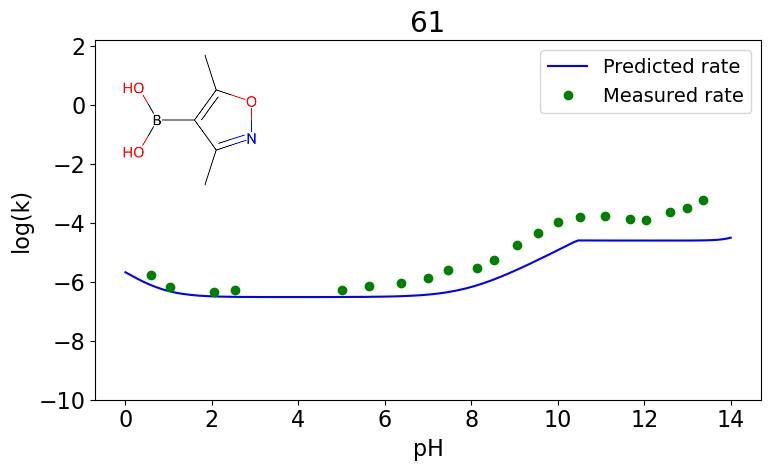

In [4]:
# Plot the protodeboronation graph
PBA_figure = PBA.plot_result()

In [5]:
# And you can of course figure out how the object was created using repr, and what molecule it 
#   is (the smiles string) using str
repr(PBA)

'KnownBoronicAcid(61)'

In [6]:
str(PBA)

'Cc1noc(C)c1B(O)O'

In [7]:
PBA

KnownBoronicAcid(61)

## Novel molecules

In [8]:
# Can also specify a molecule which we don't have ground truth for
# E.g. (2-methylpyridin-3-yl)boronic acid aka. MPBA
MPBA = KnownBoronicAcid(106)

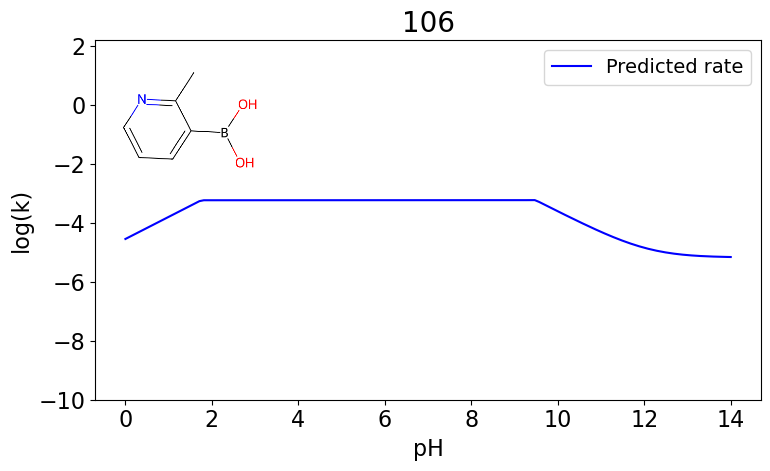

In [9]:
# Plot the protodeboronation graph
# In this case, the measured rate will of course not be plotted, 
#    since measurements for this molecule don't exist
MPBA_figure = MPBA.plot_result()

In [10]:
# And again we can easily find the relevant information about this molecule
MPBA.__dict__

{'molecule_ID': 106,
 'k1': None,
 'k2': -5.1709884045444925,
 'k2Ar': None,
 'k2cat': None,
 'k3': None,
 'k4': -3.228637209849788,
 'k5': None,
 'pKa': 9.484599999999999,
 'pKaH': 1.7525000000000002,
 'smiles': 'OB(O)C1=CC=C(OC(F)(F)F)C=C1'}

In [11]:
# you can also access the rate prediction at a specific pH
pH = 4
specific_rate = MPBA.total_rate_point_predictor(pH)
specific_rate

-3.2286368279205333

In [12]:
# Or alternatively one can convert the predicted rate of protodeboronation to a halflife:
pH = 4
halflife = MPBA.halflife(pH)
halflife

(19.56, 'minutes')

In [13]:
# And you can of course figure out how the object was created using repr, and what molecule it 
#   is (the smiles string) using str
repr(MPBA)

'KnownBoronicAcid(106)'

In [14]:
str(MPBA)

'OB(O)C1=CC=C(OC(F)(F)F)C=C1'

In [15]:
print(MPBA)

OB(O)C1=CC=C(OC(F)(F)F)C=C1


## Generate all prediction figures

In [16]:
from tqdm import tqdm

100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


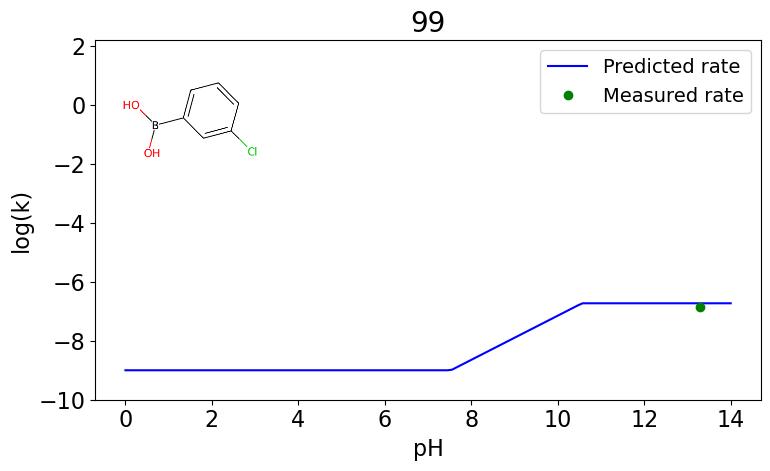

In [17]:
# Cox: generate all the measured vs predicted plots
measurements = pd.read_csv('data/Cox-molecules/Cox-molecules-data.csv')
valid_molecules = list(set(list(measurements['molecule_number'])))

for mol in tqdm(valid_molecules):
    molecule = KnownBoronicAcid(mol)
    molecule.plot_result()

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


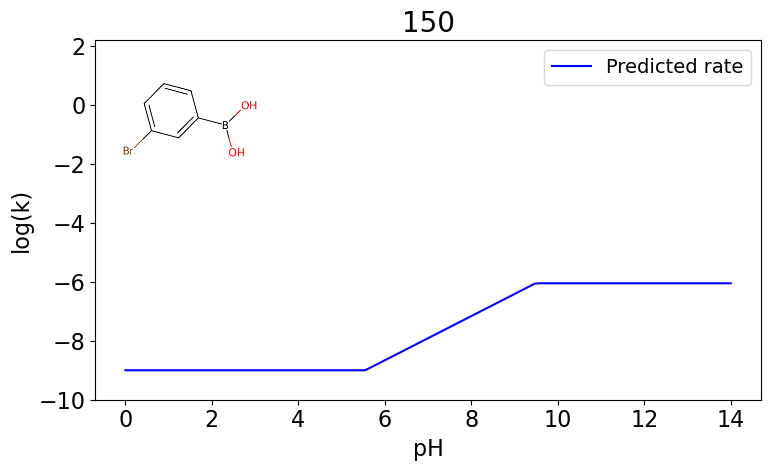

In [18]:
# novel: generate all the predicted plots
valid_molecules = range(101,151)

for mol in tqdm(valid_molecules):
    molecule = KnownBoronicAcid(mol)
    molecule.plot_result()

# Training and saving linear mechanistic models

In [19]:
from sklearn.linear_model import LinearRegression
import pickle
import pandas as pd
import numpy as np

In [20]:
def train_and_save_model(mechanism):
    df = pd.read_csv(f"data/Cox-molecules/{mechanism}.csv")
    #remove null values
    df = df[df.delta_E.notnull()]
    df = df[df.k_obs_max.notnull()]
    # extract the transition state energy and rate data and transform to np.array
    delta_E_training = np.array(df["delta_E"]).reshape((-1, 1))
    k_obs_training = np.array(df["k_obs_max"])

    # train linear regression model
    model = LinearRegression().fit(
        delta_E_training, k_obs_training
    )
    
    # save the model to disk
    filename = f'models/{mechanism}_model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [21]:
# train and save all the models
mechanisms = ["k1", "k2", "k2Ar", "k2cat", "k3", "k4", "k5"]
for mechanism in mechanisms:
    train_and_save_model(mechanism)

In [22]:
# load the model from disk
filename = "models/k1_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

# Generate predictions for your own molecules

In [23]:
# You can also create predictions using your own DFT calculations and pKa/pKaH data

In [24]:
from PDB_predictions import BoronicAcid

In [31]:
# __init__(self, k1, k2, k2Ar, k2cat, k3, k4, k5, pKa, pKaH=None ):
# Follow the syntax of the init function to populate the constructor.
# If the mechanistic pathway is active, give the energy difference
# If the mechanistic pathway is inactive, simply put None
# In the example below k1, k2, and k2cat are active (random numbers were used for energies)
new_BA = BoronicAcid(-0.022129365, 0.019614489, 0.042674721, None, None, 0.006001089, None, 9.15, 5)

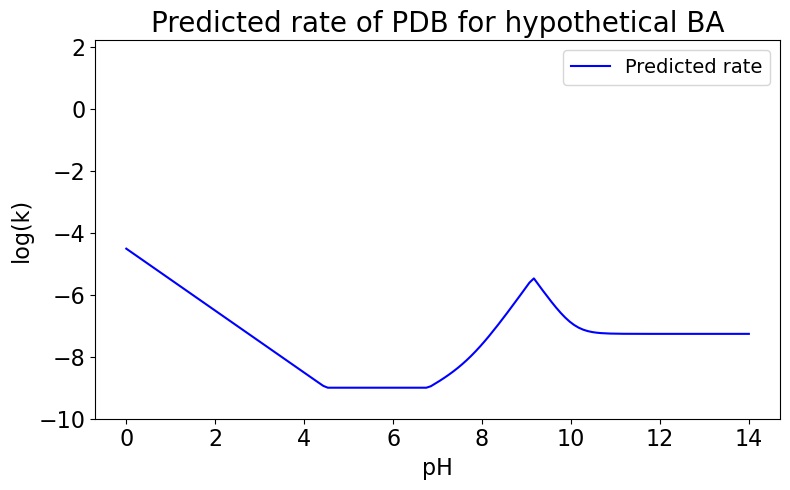

In [32]:
new_BA_fig = new_BA.plot_result("Predicted rate of PDB for hypothetical BA")

In [33]:
# And you can of course still access info about this molecule
new_BA.__dict__

{'k1': -4.516800273795681,
 'k2': -7.2640306691016425,
 'k2Ar': None,
 'k2cat': -5.452298359142709,
 'k3': None,
 'k4': None,
 'k5': None,
 'pKa': 9.15,
 'pKaH': None}

In [34]:
# And you can of course figure out how the object was created using repr
repr(new_BA)

'BoronicAcid(-4.516800273795681, -7.2640306691016425, None, -5.452298359142709, None, None, None, 9.15, None)'

In [37]:
# you can also access the rate prediction at a specific pH
pH = 2
specific_rate = new_BA.total_rate_point_predictor(pH)
specific_rate

-6.516799936466603

In [38]:
# Or alternatively one can convert the predicted rate of protodeboronation to a halflife:
pH = 2
halflife = new_BA.halflife(pH)
halflife

(26.37, 'days')